In [57]:
import sys
import os
sys.path.insert(0, os.path.abspath('../..'))
from scipy.io import loadmat
from pathlib import Path
import matplotlib.patches as patches
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
# the following import is required for matplotlib < 3.2:
from mpl_toolkits.mplot3d import Axes3D  # noqa
from scipy import stats
from scipy.stats import mannwhitneyu, ttest_rel
from scipy.signal import butter, filtfilt
import mne
import eeg_analysis.funcs4eeg as fe
import re
import imp
import ast
import behavior.func4behav as fb
imp.reload(fe)
imp.reload(fb)

from scipy import signal
from scipy.signal import resample
from scipy.ndimage import zoom
import multiprocessing as mp

In [58]:
case_title = 'endo invalid'
case_list = [case_title+' fast', case_title+' slow']
if 'endo' in case_title:
    tmax_list = [1.5+1+0.5+0.05+1, 1.5+1+1+0.05+1]
else:
    tmax_list = [1.5+0.033*4+0.5+0.05+1, 1.5+0.033*4+1+0.05+1]

fs = 1200
for i, case in enumerate(case_list):
    tmax = tmax_list[i]
    watch = '1 fixation'
    tmin = 0 # include fix or not?

    highpass = None # 0.3
    lowpass = None

    EP_lists, RT_lists = fe.pipeline_session_RT(case, watch, tmin, tmax, hipass=highpass, lopass=lowpass, baseline=(0,0), move_baseline=False, detrend=1)

    if 'slow' in case:
        sessions_slow = EP_lists
        rts_slow = RT_lists
    else:
        sessions_fast = EP_lists
        rts_fast = RT_lists


In [59]:
eegs_list = [sessions_fast, sessions_slow]
rts_list = [rts_fast, rts_slow]
session_names = ["sham before", "sham after", "real before", "real after"]
freq_band_names = ["theta", "alpha", "beta", "gamma"]
region_names = ["frontal", "central", "parietal", "occipital", "temporal"] # , "all"]
stage_names_endo = ["fixation", "cue", "wait", "response", "until response"]
stage_names_exo = ["fixation", "wait", "response", "until response"]
freq_bands = [[4, 8], [8, 12], [12, 30], [30, 50]]
endo_fast_stages = [[0, 1.5], [1.5, 1.5+1], [1.5+1, 1.5+1+0.5], [1.5+1+0.5+0.05, 1.5+1+0.5+0.05+0.3], [0, 1.5+1+0.5+0.05]]
endo_slow_stages = [[0, 1.5], [1.5, 1.5+1], [1.5+1, 1.5+1+1], [1.5+1+1+0.05, 1.5+1+1+0.05+0.3], [0, 1.5+1+1+0.05]]
exo_fast_stages = [[0, 1.5], [1.5+0.033*4, 1.5+0.033*4+0.5], [1.5+0.033*4+0.5+0.05, 1.5+0.033*4+0.5+0.05+0.3], [0, 1.5+0.033*4+0.5+0.05]]
exo_slow_stages = [[0, 1.5], [1.5+0.033*4, 1.5+0.033*4+1], [1.5+0.033*4+1+0.05, 1.5+0.033*4+1+0.05+0.3], [0, 1.5+0.033*4+1+0.05]]

if 'endo' in case_title:
    stages_list = [endo_fast_stages, endo_slow_stages]
    stage_names = stage_names_endo
else:
    stages_list = [exo_fast_stages, exo_slow_stages]
    stage_names = stage_names_exo
bp_rt = pd.DataFrame(columns=['stage', 'band', 'region', 'session', 'group_id', 'band power', 'reaction time'])

In [60]:
for i, sessions in enumerate(eegs_list):
    rts = rts_list[i]
    stage_list = stages_list[i]
    for j, session_name in enumerate(session_names):
        session_eeg = sessions[j]
        session_rt = rts[j]
        # print(session_name)
        for group_id in range(9):
            # print(group_id)
            eeg = session_eeg[group_id]
            rt = session_rt[group_id]
            for trial in range(eeg.shape[0]):
                trial_data = eeg[trial,:,:]
                for k, stage in enumerate(stage_list):
                    stage_start = int(stage[0]*fs)
                    stage_end = int(stage[1]*fs)
                    psds, freqs = mne.time_frequency.psd_array_multitaper(trial_data[:,stage_start:stage_end], fs, fmin=1, fmax=51, verbose=False)
                    for l, freq_band in enumerate(freq_bands):
                        bp = fe.band_power(psds, freqs, freq_band)
                        for region in region_names:
                            channels_dict = fe.pick_cortex(region)
                            channel_names_list = list(channels_dict.keys())
                            channels = [channels_dict[key]-1 for key in channel_names_list]
                            bp_region = np.nanmean(bp[channels])
                            new_row = pd.DataFrame({
                                'stage': [stage_names[k]],
                                'band': [freq_band_names[l]],
                                'region': [region],
                                'session': [session_name],
                                'group_id': [group_id],
                                'band power': [bp_region],
                                'reaction time': [rt[trial]]
                            })
                            bp_rt = pd.concat([bp_rt, new_row], ignore_index=True)
bp_rt
# 11 min 32 s for endo or exo
# 42 s for endo invalid
# 6 min 7.7 s for endo valid

,stage,band,region,session,group_id,band power,reaction time
0,fixation,theta,frontal,sham before,0,4.379796e-09,0.42679
1,fixation,theta,central,sham before,0,6.614999e-09,0.42679
2,fixation,theta,parietal,sham before,0,3.735611e-09,0.42679
3,fixation,theta,occipital,sham before,0,4.138496e-09,0.42679
4,fixation,theta,temporal,sham before,0,4.619048e-09,0.42679
...,...,...,...,...,...,...,...
35695,until response,gamma,frontal,real after,8,9.010658e-10,0.35396
35696,until response,gamma,central,real after,8,7.586944e-10,0.35396
35697,until response,gamma,parietal,real after,8,9.954150e-10,0.35396
35698,until response,gamma,occipital,real after,8,8.650689e-10,0.35396


In [61]:
# average for session (4*9)
bp_rt_session = pd.DataFrame(columns=['stage', 'band', 'region', 'session', 'band power', 'reaction time'])
for stage in stage_names:
    for band in freq_band_names:
        for region in region_names:
            for session in session_names:
                for group_id in range (9):
                    bp_mean = bp_rt[(bp_rt['stage']==stage) & (bp_rt['band']==band) & (bp_rt['region']==region) & (bp_rt['session']==session) & (bp_rt['group_id']==group_id)]['band power'].mean()
                    rt_mean = bp_rt[(bp_rt['stage']==stage) & (bp_rt['band']==band) & (bp_rt['region']==region) & (bp_rt['session']==session) & (bp_rt['group_id']==group_id)]['reaction time'].mean()
                    new_row = pd.DataFrame({
                        'stage': [stage],
                        'band': [band],
                        'region': [region],
                        'session': [session],
                        'band power': [bp_mean],
                        'reaction time': [rt_mean]
                    })
                    bp_rt_session = pd.concat([bp_rt_session, new_row], ignore_index=True)
bp_rt_session
# 5 m 23.3 s for endo or exo
# 1 m 2.9 s for endo invalid
# 4 m 9.4 s for endo valid

,stage,band,region,session,band power,reaction time
0,fixation,theta,frontal,sham before,4.897839e-09,0.396738
1,fixation,theta,frontal,sham before,1.751666e-09,0.272630
2,fixation,theta,frontal,sham before,6.385192e-09,0.326898
3,fixation,theta,frontal,sham before,9.784518e-09,0.292787
4,fixation,theta,frontal,sham before,8.157503e-08,0.304247
...,...,...,...,...,...,...
3595,until response,gamma,temporal,real after,4.161968e-09,0.303678
3596,until response,gamma,temporal,real after,2.781248e-09,0.292421
3597,until response,gamma,temporal,real after,1.700934e-09,0.236993
3598,until response,gamma,temporal,real after,1.388771e-09,0.350270


In [62]:
# # plot by sessions
# def remove_max_val(arr1, arr2):
#     max_idx = np.argmax(arr1)
#     arr1 = np.delete(arr1, max_idx)
#     arr2 = np.delete(arr2, max_idx)
#     return arr1, arr2

# def remove_min_val(arr1, arr2):
#     max_idx = np.argmin(arr1)
#     arr1 = np.delete(arr1, max_idx)
#     arr2 = np.delete(arr2, max_idx)
#     return arr1, arr2

# def remove_outliers(case_title, bps, rts):
#     if case_title == 'endo valid':
#         bps, rts = remove_max_val(bps, rts)
#         bps, rts = remove_min_val(bps, rts)
#         rts, bps = remove_max_val(rts, bps)
#         rts, bps = remove_min_val(rts, bps)

#     elif case_title == 'endo invalid':
#         bps, rts = remove_max_val(bps, rts)
#         bps, rts = remove_min_val(bps, rts)
#         rts, bps = remove_max_val(rts, bps)
#         rts, bps = remove_min_val(rts, bps)

#         bps, rts = remove_max_val(bps, rts)
#         bps, rts = remove_min_val(bps, rts)
#         rts, bps = remove_max_val(rts, bps)
#         rts, bps = remove_min_val(rts, bps)

#     elif case_title == 'exo valid':
#         bps, rts = remove_max_val(bps, rts)
#         bps, rts = remove_min_val(bps, rts)
#         rts, bps = remove_max_val(rts, bps)
#         rts, bps = remove_min_val(rts, bps)

#     return bps, rts


# plot_table = pd.DataFrame(columns=['stage', 'band', 'region', 'session', 'mean', 'std error'])
# for stage in stage_names:
#     for band in freq_band_names:
#         for region in region_names:
#             current_table = bp_rt_session[(bp_rt_session['stage']==stage) & (bp_rt_session['band']==band) & (bp_rt_session['region']==region)]
#             bps = current_table['band power'].values
#             rts = current_table['reaction time'].values
#             bps, rts = remove_outliers(case_title, bps, rts)

#             matched_rows = pd.DataFrame()
#             for bp_value, rt_value in zip(bps, rts):
#                 mask = (current_table['band power'] == bp_value) & (current_table['reaction time'] == rt_value)
#                 matched_rows = pd.concat([matched_rows, current_table[mask]])

#             for session_name in session_names:
#                 numbers = matched_rows[matched_rows['session']==session_name].shape[0]
#                 session_mean = matched_rows[matched_rows['session']==session_name]['band power'].mean()
#                 session_std_error = matched_rows[matched_rows['session']==session_name]['band power'].std() / np.sqrt(numbers)
#                 new_row = pd.DataFrame({
#                     'stage': [stage],
#                     'band': [band],
#                     'region': [region],
#                     'session': [session_name],
#                     'mean': [session_mean],
#                     'std error': [session_std_error]
#                 })
#                 plot_table = pd.concat([plot_table, new_row], ignore_index=True)


# plot_table

In [63]:
plot_table = pd.DataFrame(columns=['stage', 'band', 'region', 'session', 'mean', 'std error'])
for stage in stage_names:
    for band in freq_band_names:
        for region in region_names:
            current_table = bp_rt[(bp_rt['stage']==stage) & (bp_rt['band']==band) & (bp_rt['region']==region)]
            for session_name in session_names:
                session_bp = current_table[current_table['session']==session_name]['band power'].values
                session_bp = fe.rm_outlier(session_bp, lower_k=1.5, upper_k=1.5)
                session_mean = np.mean(session_bp)
                session_std_error = np.std(session_bp) / np.sqrt(len(session_bp))
                new_row = pd.DataFrame({
                    'stage': [stage],
                    'band': [band],
                    'region': [region],
                    'session': [session_name],
                    'mean': [session_mean],
                    'std error': [session_std_error]
                })
                plot_table = pd.concat([plot_table, new_row], ignore_index=True)


plot_table# [(plot_table['band']=='beta') & (plot_table['region']=='frontal')]

,stage,band,region,session,mean,std error
0,fixation,theta,frontal,sham before,8.330271e-09,6.390792e-10
1,fixation,theta,frontal,sham after,8.086267e-09,8.342814e-10
2,fixation,theta,frontal,real before,4.145286e-09,2.666612e-10
3,fixation,theta,frontal,real after,4.676451e-09,3.642129e-10
4,fixation,theta,central,sham before,1.018897e-08,7.349372e-10
...,...,...,...,...,...,...
395,until response,gamma,occipital,real after,1.996072e-09,9.001487e-11
396,until response,gamma,temporal,sham before,3.308251e-09,2.853539e-10
397,until response,gamma,temporal,sham after,2.628908e-09,1.735460e-10
398,until response,gamma,temporal,real before,2.582689e-09,1.437210e-10


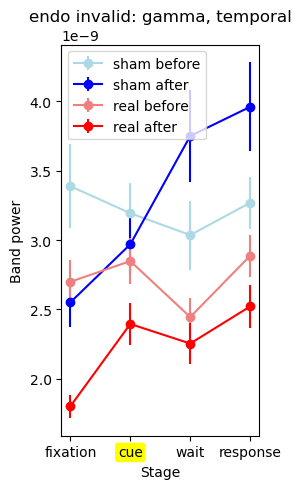

In [68]:
import matplotlib.pyplot as plt

band = 'gamma'
region = 'temporal'
# Filter plot_table for 'band' equals 'beta' and 'region' equals 'frontal'
filtered_table = plot_table[(plot_table['band'] == band) & (plot_table['region'] == region)]

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(3, 5))

colors = ['lightblue', 'blue', 'lightcoral', 'red']
session_names = ["sham before", "sham after", "real before", "real after"]
stage_name_cut = stage_names[:-1]  # Removed the last stage

# Iterate over session names to plot each line
for i, session_name in enumerate(session_names):
    session_data = filtered_table[filtered_table['session'] == session_name]
    
    # Get mean and std error values for each stage
    means = session_data['mean'].values[:-1]  # Exclude the last stage
    std_errors = session_data['std error'].values[:-1]  # Exclude the last stage
    
    # Plot on the plot
    ax.errorbar(stage_name_cut, means, yerr=std_errors, color=colors[i], label=session_name, marker='o', linestyle='-')

# Customize the plot
ax.set_xlabel('Stage')
ax.set_ylabel('Band power')
ax.set_title(case_title + ': ' + band + ', ' + region)
ax.legend()# title='Session')

# Display the plot
plt.tight_layout()

plt.draw()
xticklabels = ax.get_xticklabels()
xticklabels[1].set_bbox(dict(facecolor='yellow', edgecolor='none', boxstyle='round,pad=0.2'))


plt.show()


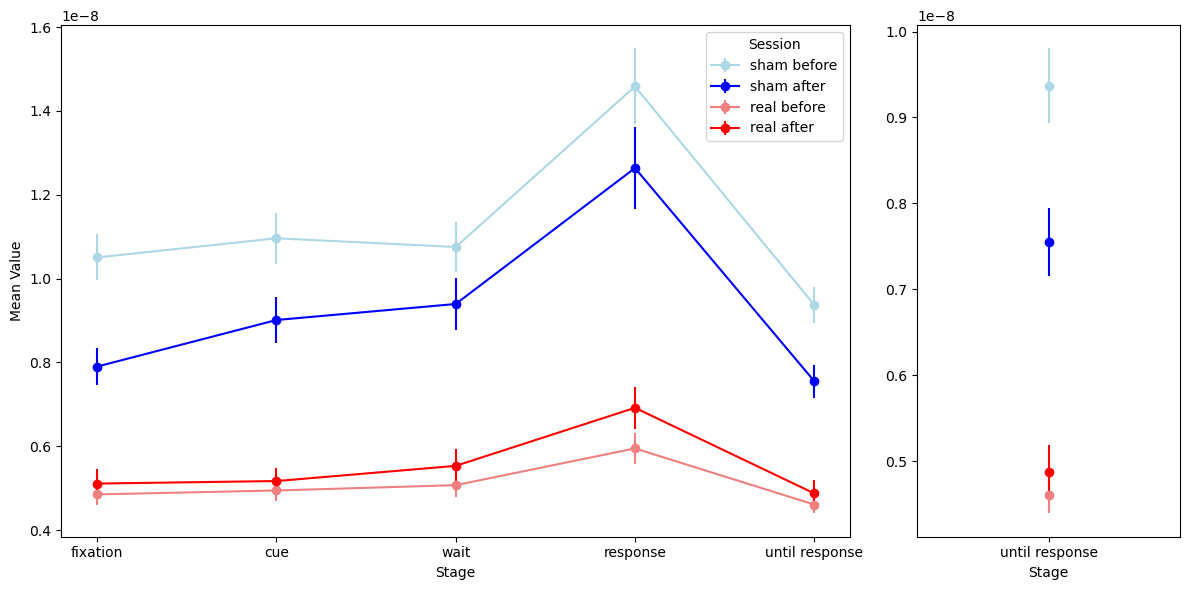

In [65]:
import matplotlib.gridspec as gridspec

# Filter plot_table for 'band' equals 'beta' and 'region' equals 'frontal'
filtered_table = plot_table[(plot_table['band'] == 'beta') & (plot_table['region'] == 'frontal')]

# Set up the figure and axes
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

colors = ['lightblue', 'blue', 'lightcoral', 'red']

# Iterate over session names to plot each line
for i, session_name in enumerate(session_names):
    session_data = filtered_table[filtered_table['session'] == session_name]
    
    # Get mean and std error values for each stage
    means = session_data['mean'].values
    std_errors = session_data['std error'].values
    
    # Plot on the left-hand side plot
    ax1.errorbar(stage_names, means, yerr=std_errors, color=colors[i], label=session_name, marker='o', linestyle='-')
    
    # Plot on the right-hand side plot for the last stage
    ax2.errorbar(stage_names[-1], means[-1], yerr=std_errors[-1], color=colors[i], marker='o', linestyle='')

# Customize the left-hand side plot
ax1.set_xlabel('Stage')
ax1.set_ylabel('Mean Value')
ax1.legend(title='Session')

# Customize the right-hand side plot
ax2.set_xlabel('Stage')
ax2.set_xticks([stage_names[-1]])  # Only show the last stage on the x-axis

# Display the plot
plt.tight_layout()
plt.show()